# Initial setup

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/fz-fyp-new/T1.csv', parse_dates=['Date/Time'])



In [ ]:
print(df.head())
print(df.info())
print("Missing values per column:")
print(df.isnull().sum())


          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV A

In [ ]:
print("\nSummary Statistics:")
print(df.describe())



Summary Statistics:
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)  
count        50530.000000  
mean           123.687559  
std             93.443736  
min              0.000000  
25%             49.315437  
50%             73.712978  
75%            201.696720  
max            359.997589  


# EDA

In [ ]:
# Convert the 'Date/Time' column to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')

# Check the first few rows to confirm the conversion
print(df.head())
print(df.info())


            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00           380.047791          5.311336   
1 2018-01-01 00:10:00           453.769196          5.672167   
2 2018-01-01 00:20:00           306.376587          5.216037   
3 2018-01-01 00:30:00           419.645905          5.659674   
4 2018-01-01 00:40:00           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50530 n

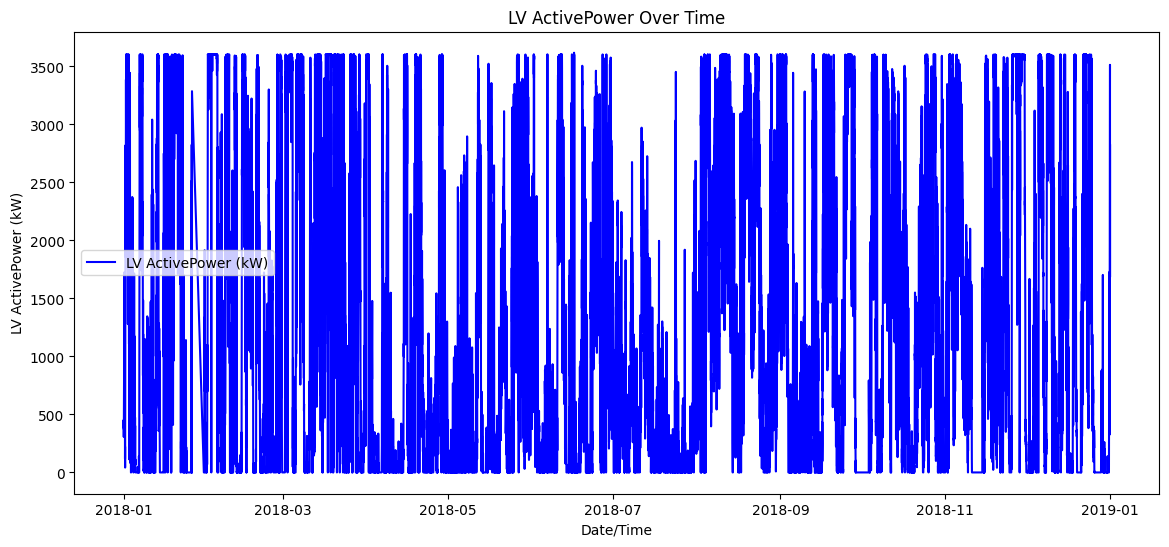

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
plt.plot(df['Date/Time'], df['LV ActivePower (kW)'], label='LV ActivePower (kW)', color='blue')
plt.xlabel('Date/Time')
plt.ylabel('LV ActivePower (kW)')
plt.title('LV ActivePower Over Time')
plt.legend()
plt.show()


This chart, titled "LV ActivePower Over Time," shows the variation of "LV ActivePower (kW)" over time during the year 2018.

### Observations:
1. **X-Axis (Date/Time):** Represents the time progression, ranging from January 2018 to December 2018.
2. **Y-Axis (LV ActivePower in kW):** Indicates the magnitude of LV ActivePower generated during the year.
3. **Pattern:** The LV ActivePower fluctuates significantly, ranging from 0 to over 3500 kW. The large number of spikes and dips suggests highly variable power output throughout the year.

### Insights:
- The irregular pattern indicates that the power generation is inconsistent, likely due to varying environmental factors such as wind speed or direction.
- High activity is observed throughout most of the year, with occasional drops to 0, potentially indicating downtime or maintenance periods.


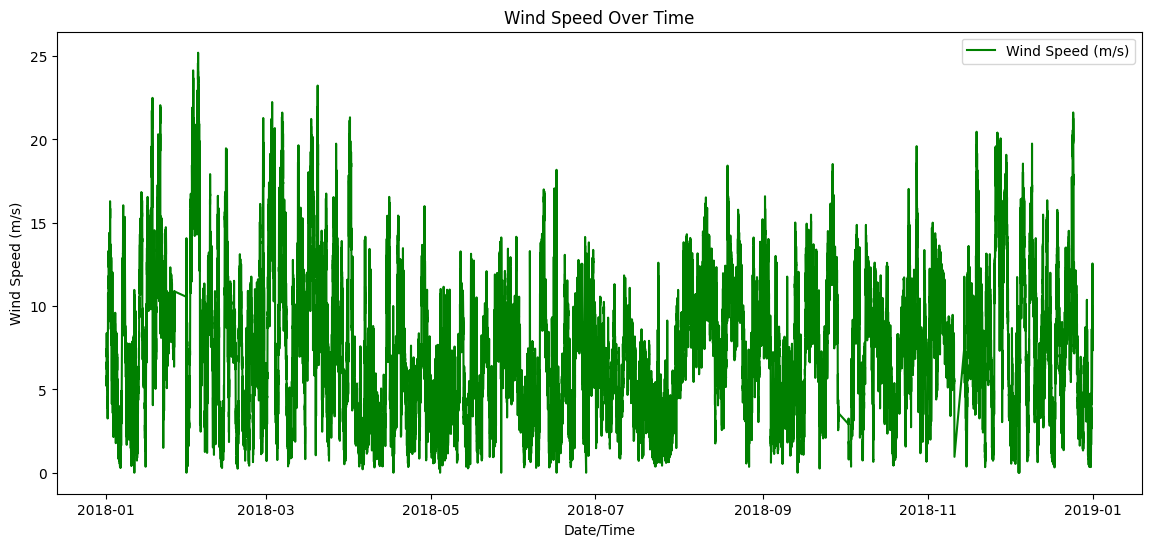

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date/Time'], df['Wind Speed (m/s)'], label='Wind Speed (m/s)', color='green')
plt.xlabel('Date/Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Over Time')
plt.legend()
plt.show()


This chart, titled "Wind Speed Over Time," illustrates the variation in wind speed throughout the year 2018.

### Observations:
1. **X-Axis (Date/Time):** Represents the time progression from January 2018 to December 2018.
2. **Y-Axis (Wind Speed in m/s):** Indicates the recorded wind speed in meters per second.
3. **Pattern:** Wind speed is highly variable but shows distinct periods of higher and lower intensity:
   - Early months (January to March) show a higher frequency of peaks.
   - Mid-year months (April to July) exhibit slightly reduced wind speed.
   - The latter part of the year (September to December) sees renewed variability with notable peaks.

### Insights:
- Wind speed peaks regularly reach up to around 25 m/s, indicative of periods of strong wind activity.
- Drops to near 0 m/s suggest calm wind conditions, possibly corresponding to downtime in wind turbine activity or low power output.
- The variability in wind speed closely influences the power output (as seen in the LV ActivePower chart), highlighting their correlation.



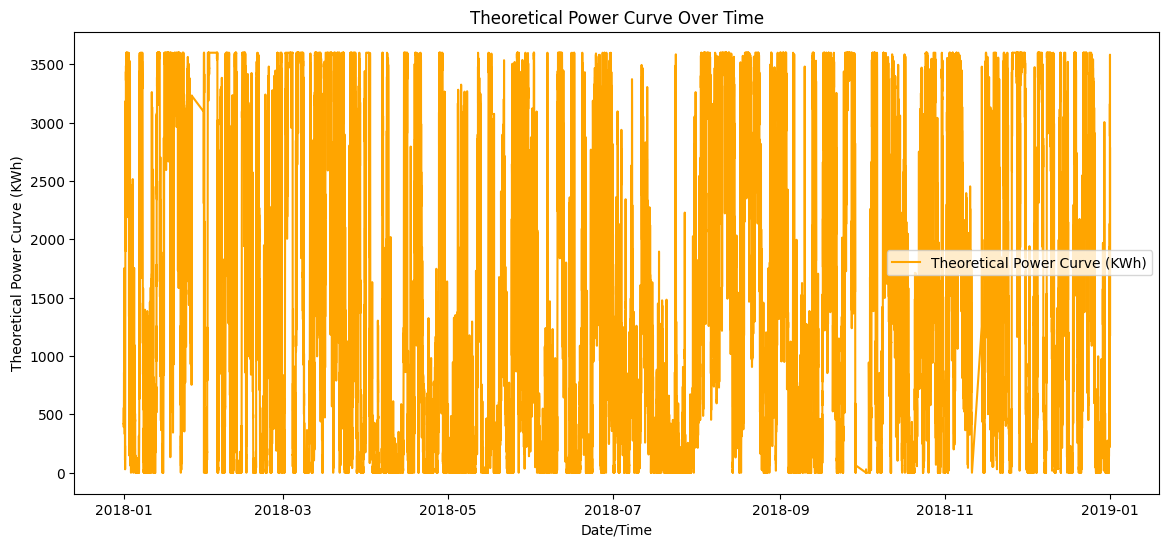

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date/Time'], df['Theoretical_Power_Curve (KWh)'], label='Theoretical Power Curve (KWh)', color='orange')
plt.xlabel('Date/Time')
plt.ylabel('Theoretical Power Curve (KWh)')
plt.title('Theoretical Power Curve Over Time')
plt.legend()
plt.show()


This chart, titled "Theoretical Power Curve Over Time," illustrates the theoretical power output (in kWh) of the wind turbine throughout the year 2018.

### Observations:
1. **X-Axis (Date/Time):** Represents the time progression from January 2018 to December 2018.
2. **Y-Axis (Theoretical Power Curve in kWh):** Indicates the predicted theoretical power output based on wind speed and turbine specifications.
3. **Pattern:** The theoretical power output exhibits frequent spikes and dips:
   - The values reach as high as 3500 kWh.
   - There are periods of lower values or even drops to near zero, which might correlate with calm wind conditions.

### Insights:
- **Fluctuations:** The variability in the theoretical power curve closely mirrors the variability in wind speed. This suggests that the theoretical power is calculated based on wind speed data and turbine performance characteristics.
- **Peaks and Dips:** The frequent peaks indicate periods of high wind speed and optimal conditions for power generation, while the dips represent lower wind speeds or turbine inactivity.
- **Theoretical vs. Actual:** Comparing this chart to the "LV ActivePower" chart reveals how closely the actual power output matches the theoretical predictions.



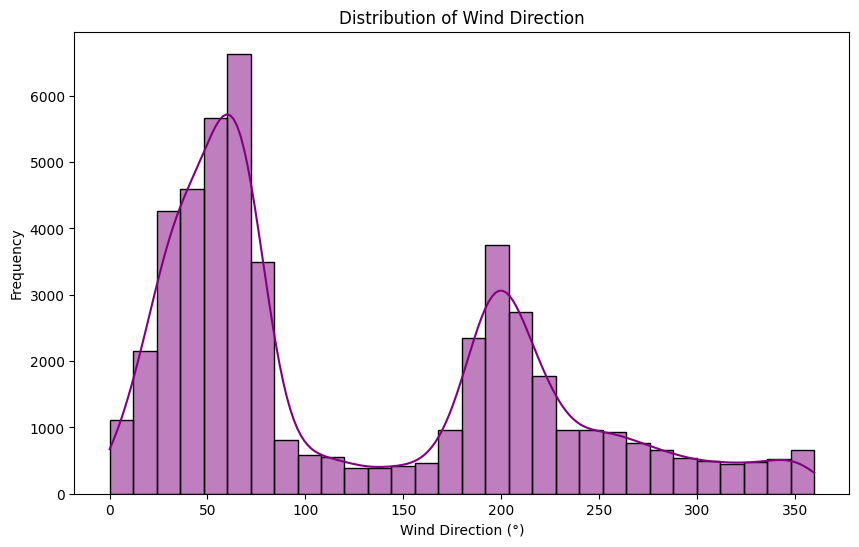

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Wind Direction (°)'], bins=30, kde=True, color='purple')
plt.xlabel('Wind Direction (°)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Direction')
plt.show()


This chart, titled "Distribution of Wind Direction," represents the frequency of wind directions (measured in degrees) throughout the dataset.

### Observations:
1. **X-Axis (Wind Direction in °):** Represents the direction of the wind, ranging from 0° to 360°.
2. **Y-Axis (Frequency):** Represents how often wind comes from a specific direction.
3. **Pattern:**
   - Two distinct peaks are visible:
     - One major peak around 50° (Northeast direction).
     - Another significant peak around 200° (South-Southwest direction).
   - There are dips in frequency between the peaks, especially from 100° to 180° and again from 250° to 360°.

### Insights:
- **Primary Wind Directions:** The dominant wind directions appear to be around 50° and 200°. This indicates that the wind turbines are likely optimized to capture wind energy coming predominantly from these directions.
- **Rare Directions:** There is minimal wind coming from directions in the range of 100°–180° and above 250°, suggesting those directions are less frequent or less favorable for energy production.
- **Bimodal Distribution:** The distribution shows a bimodal shape, indicating two dominant wind flow patterns during the recorded period.



In [ ]:
print("Missing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64


# Data preprocessng

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['LV ActivePower (kW)'].quantile(0.25)
Q3 = df['LV ActivePower (kW)'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"LV ActivePower (kW) - Lower bound: {lower_bound}, Upper bound: {upper_bound}")

# Filter the data to remove outliers for this column (if needed)
df_no_outliers = df[(df['LV ActivePower (kW)'] >= lower_bound) & (df['LV ActivePower (kW)'] <= upper_bound)]


LV ActivePower (kW) - Lower bound: -3597.0666279792786, Upper bound: 6130.252086162567


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the features to scale (you can include all numerical columns if appropriate)
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)',
            'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

# Check the first few rows after scaling
print(df_scaled.head())



            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00             0.105633          0.210717   
1 2018-01-01 00:10:00             0.125991          0.225032   
2 2018-01-01 00:20:00             0.085289          0.206936   
3 2018-01-01 00:30:00             0.116568          0.224537   
4 2018-01-01 00:40:00             0.105800          0.221294   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                       0.115647            0.722213  
1                       0.144422            0.746230  
2                       0.108583            0.757129  
3                       0.143369            0.753500  
4                       0.136584            0.737989  


# Feature engineering

In [ ]:
df_scaled['hour'] = df_scaled['Date/Time'].dt.hour           # Hour of the day (0-23)
df_scaled['day'] = df_scaled['Date/Time'].dt.day             # Day of the month
df_scaled['month'] = df_scaled['Date/Time'].dt.month          # Month (1-12)
df_scaled['day_of_week'] = df_scaled['Date/Time'].dt.dayofweek  # Day of week (0=Monday, 6=Sunday)
df_scaled['week'] = df_scaled['Date/Time'].dt.isocalendar().week  # ISO week number

In [ ]:
# For Hour (24-hour cycle)
df_scaled['Hour_sin'] = np.sin(2 * np.pi * df_scaled['hour'] / 24)
df_scaled['Hour_cos'] = np.cos(2 * np.pi * df_scaled['hour'] / 24)

# For Month (12-month cycle)
df_scaled['Month_sin'] = np.sin(2 * np.pi * df_scaled['month'] / 12)
df_scaled['Month_cos'] = np.cos(2 * np.pi * df_scaled['month'] / 12)

# For Wind Direction (0-360° cycle)
df_scaled['wd_sin'] = np.sin(np.radians(df_scaled['Wind Direction (°)']))
df_scaled['wd_cos'] = np.cos(np.radians(df_scaled['Wind Direction (°)']))

In [ ]:
df_scaled['LV_ActivePower_roll6'] = df_scaled['LV ActivePower (kW)'].rolling(window=6).mean()
df_scaled['Wind_Speed_roll6'] = df_scaled['Wind Speed (m/s)'].rolling(window=6).mean()


In [ ]:
df_scaled['WindSpeed_TheoreticalProduct'] = df_scaled['Wind Speed (m/s)'] * df_scaled['Theoretical_Power_Curve (KWh)']


In [ ]:
df_scaled = df_scaled.dropna().reset_index(drop=True)

In [ ]:
print("Enhanced DataFrame with Additional Features:")
print(df_scaled.head())

Enhanced DataFrame with Additional Features:
            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:50:00             0.111804          0.222330   
1 2018-01-01 01:00:00             0.124289          0.229826   
2 2018-01-01 01:10:00             0.107620          0.210507   
3 2018-01-01 01:20:00             0.128720          0.221559   
4 2018-01-01 01:30:00             0.122113          0.219123   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  hour  day  month  \
0                       0.138732            0.734946     0    1      1   
1                       0.154826            0.739348     1    1      1   
2                       0.115249            0.716531     1    1      1   
3                       0.137133            0.704118     1    1      1   
4                       0.132141            0.718682     1    1      1   

   day_of_week  week  Hour_sin  Hour_cos  Month_sin  Month_cos    wd_sin  \
0            0     1  0.000000  1.000000        0

In [ ]:
df_scaled['Power_lag1'] = df_scaled['LV ActivePower (kW)'].shift(1)
df_scaled['Power_lag2'] = df_scaled['LV ActivePower (kW)'].shift(2)
df_scaled['Power_lag3'] = df_scaled['LV ActivePower (kW)'].shift(3)

# Create lag features for Wind Speed (m/s)
df_scaled['WindSpeed_lag1'] = df_scaled['Wind Speed (m/s)'].shift(1)
df_scaled['WindSpeed_lag2'] = df_scaled['Wind Speed (m/s)'].shift(2)
df_scaled['WindSpeed_lag3'] = df_scaled['Wind Speed (m/s)'].shift(3)

# Create rolling average features using a window of 3 timesteps
df_scaled['WindSpeed_rolling_mean_3'] = df_scaled['Wind Speed (m/s)'].rolling(window=3).mean()
df_scaled['Power_rolling_mean_3'] = df_scaled['LV ActivePower (kW)'].rolling(window=3).mean()

# Optionally, drop the initial rows that now contain NaN values due to shifting/rolling.
df_scaled.dropna(inplace=True)
df_scaled.reset_index(drop=True, inplace=True)

print("Lag and Rolling Features added:")
print(df_scaled[['Power_lag1', 'Power_lag2', 'Power_lag3',
          'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
          'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3']].head())

Lag and Rolling Features added:
   Power_lag1  Power_lag2  Power_lag3  WindSpeed_lag1  WindSpeed_lag2  \
0    0.107620    0.124289    0.111804        0.210507        0.229826   
1    0.128720    0.107620    0.124289        0.221559        0.210507   
2    0.122113    0.128720    0.107620        0.219123        0.221559   
3    0.138256    0.122113    0.128720        0.227093        0.219123   
4    0.146163    0.138256    0.122113        0.235428        0.227093   

   WindSpeed_lag3  WindSpeed_rolling_mean_3  Power_rolling_mean_3  
0        0.222330                  0.220631              0.120210  
1        0.229826                  0.217063              0.119484  
2        0.210507                  0.222592              0.129697  
3        0.221559                  0.227215              0.135511  
4        0.219123                  0.240759              0.160444  


# Train test split

In [ ]:
split_index = int(len(df_scaled) * 0.75)
train_df = df_scaled.iloc[:split_index].copy()
test_df  = df_scaled.iloc[split_index:].copy()

In [ ]:
features = [
    'Wind Speed (m/s)', 'wd_sin', 'wd_cos',
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
    'Power_lag1', 'Power_lag2', 'Power_lag3',
    'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
    'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3'
]


In [ ]:
X_train = train_df[features].values
y_train = train_df['LV ActivePower (kW)'].values

X_test = test_df[features].values
y_test = test_df['LV ActivePower (kW)'].values

## XGBoost hyperparameter tuning

In [ ]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_distributions = {
    'n_estimators': [300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': list(range(3, 11)),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 1],
    'min_child_weight': [1, 2, 5, 10]
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
print("Starting XGBoost hyperparameter tuning...")
random_search.fit(X_train, y_train)
best_xgb_params = random_search.best_params_
print("Best XGBoost Hyperparameters:", best_xgb_params)

# Train final XGBoost model on full training data
final_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_xgb_params)
final_xgb.fit(X_train, y_train)
xgb_train_preds = final_xgb.predict(X_train)


Starting XGBoost hyperparameter tuning...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best XGBoost Hyperparameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


## ARIMA residual model tuning

In [ ]:
resid_train = y_train - xgb_train_preds


In [ ]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_aic = np.inf
best_order = None
best_arima_model = None

In [ ]:
print("Tuning ARIMA model on residuals...")
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(resid_train, order=(p, d, q))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, d, q)
            best_arima_model = results
    except Exception as e:
        # If the model fails for a given order, skip it.
        continue

print("Best ARIMA order:", best_order, "with AIC:", best_aic)

Tuning ARIMA model on residuals...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA order: (2, 1, 1) with AIC: -283166.7537092891


## hybrid forecasting

In [ ]:
xgb_test_preds = final_xgb.predict(X_test)


In [ ]:
n_steps = len(y_test)
arima_resid_forecast = best_arima_model.forecast(steps=n_steps)

# Final hybrid forecast: XGBoost prediction + ARIMA residual forecast.
hybrid_test_preds = xgb_test_preds + arima_resid_forecast

# Evaluate performance on test set.
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_test_preds))
hybrid_r2 = r2_score(y_test, hybrid_test_preds)

print("Hybrid Model Performance on Test Set:")
print("RMSE:", hybrid_rmse)
print("R²:", hybrid_r2)

Hybrid Model Performance on Test Set:
RMSE: 0.012690602261375113
R²: 0.9987885980536367


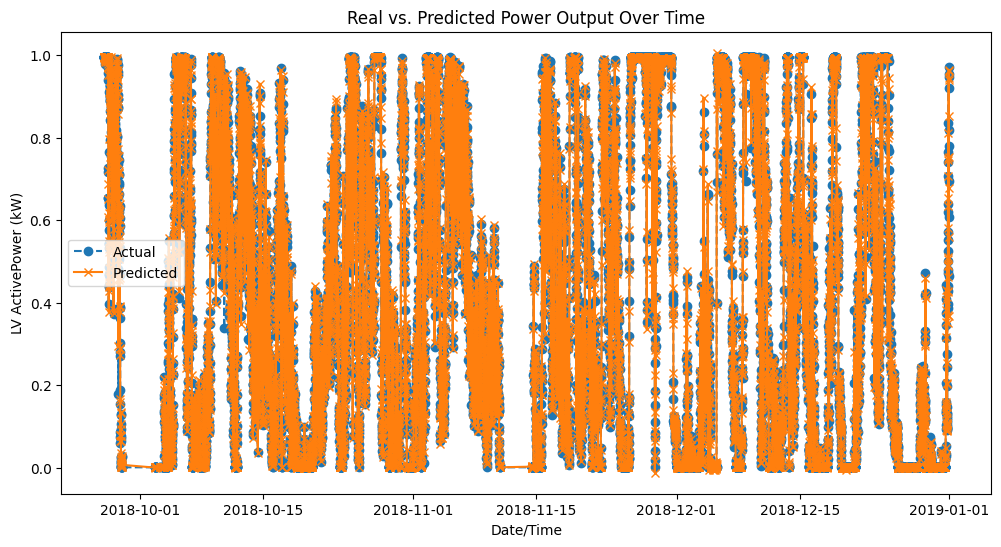

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_df['Date/Time'], y_test, label='Actual', marker='o', linestyle='--')
plt.plot(test_df['Date/Time'], hybrid_test_preds, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Date/Time')
plt.ylabel('LV ActivePower (kW)')
plt.title('Real vs. Predicted Power Output Over Time')
plt.legend()
plt.show()


In [ ]:
model_save_path = "/content/drive/MyDrive/fz-fyp-new/track 1/hybrid_model_xg_arima"
os.makedirs(model_save_path, exist_ok=True)
joblib.dump(final_xgb, os.path.join(model_save_path, "final_xgb_model.pkl"))
joblib.dump(best_arima_model, os.path.join(model_save_path, "best_arima_model.pkl"))
print("Hybrid models saved.")

Hybrid models saved.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler()

# Suppose your original target column is 'LV ActivePower (kW)'
# We'll split the DataFrame into train/test first to avoid data leakage.
split_index = int(len(df) * 0.75)
train_df = df.iloc[:split_index].copy()
test_df  = df.iloc[split_index:].copy()

# Fit the scaler on the *training* target only
train_df['LV ActivePower_scaled'] = target_scaler.fit_transform(train_df[['LV ActivePower (kW)']])
test_df['LV ActivePower_scaled']  = target_scaler.transform(test_df[['LV ActivePower (kW)']])


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Suppose your scaled predictions are in y_pred_scaled
# and your actual scaled values are in y_test_scaled
# (extracted from test_df['LV ActivePower_scaled'])

# 1. Invert predictions
y_pred_inverted = target_scaler.inverse_transform(hybrid_test_preds.reshape(-1, 1)).flatten()

# 2. Invert actual scaled values
y_test_inverted = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 3. Compute metrics in original kW units
rmse_original = np.sqrt(mean_squared_error(y_test_inverted, y_pred_inverted))
r2_original = r2_score(y_test_inverted, y_pred_inverted)

print("RMSE (kW):", rmse_original)
print("R²:", r2_original)


RMSE (kW): 45.95526367119502
R²: 0.9987885980536367


x_axis length: 12630
y_test_inverted length: 12631


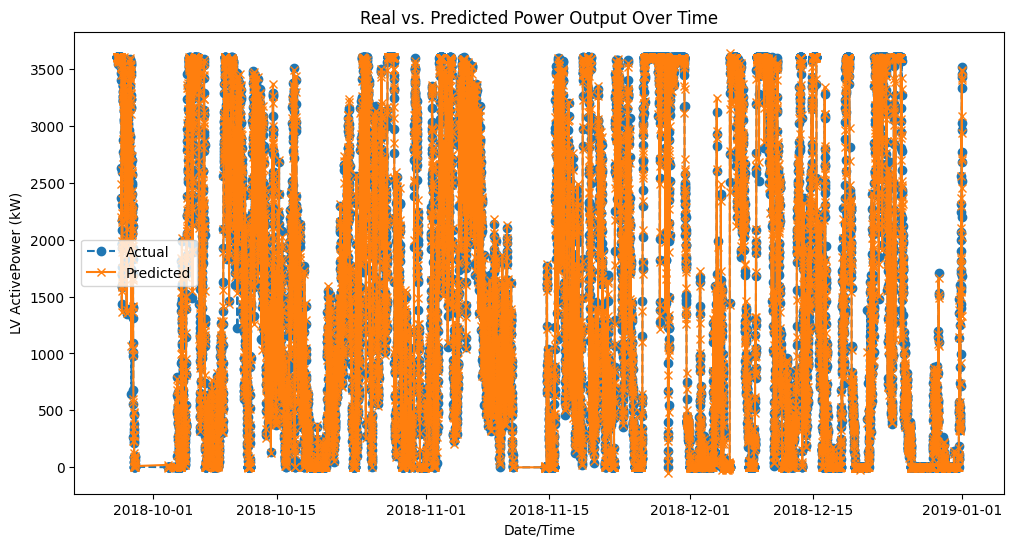

In [ ]:
# Define window_size (if not already defined)
window_size = 3

# Create an x-axis from the Date/Time column, starting from index 'window_size'
x_axis = test_df['Date/Time'].iloc[window_size:]

# Compare lengths of x_axis and y_test_inverted
print("x_axis length:", len(x_axis))
print("y_test_inverted length:", len(y_test_inverted))

# Trim the longer array so both have the same length
if len(x_axis) > len(y_test_inverted):
    x_axis = x_axis.iloc[:len(y_test_inverted)]
elif len(y_test_inverted) > len(x_axis):
    y_test_inverted = y_test_inverted[:len(x_axis)]
    y_pred_inverted = y_pred_inverted[:len(x_axis)]

# Now, plot the aligned arrays
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(x_axis, y_test_inverted, label='Actual', marker='o', linestyle='--')
plt.plot(x_axis, y_pred_inverted, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Date/Time')
plt.ylabel('LV ActivePower (kW)')
plt.title('Real vs. Predicted Power Output Over Time')
plt.legend()
plt.show()
